Import the necessary libraries

In [81]:
!pip install transformers
!pip install ipywidgets
!pip install pytorch-lightning==1.5.10
!pip install nvidia-ml-py3
!pip install neptune-client
!pip install lightning-bolts
!pip install torchmetrics

  Using cached pytorch_lightning-1.5.10-py3-none-any.whl (527 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.9.5
    Uninstalling pytorch-lightning-1.9.5:
      Successfully uninstalled pytorch-lightning-1.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning-bolts 0.7.0 requires pytorch-lightning<2.0.0,>1.7.0, but you have pytorch-lightning 1.5.10 which is incompatible.
  Using cached pytorch_lightning-1.9.5-py3-none-any.whl (829 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.5.10
    Uninstalling pytorch-lightning-1.5.10:
      Successfully uninstalled pytorch-lightning-1.5.10


In [82]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2Config
import torch
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2FeatureEncoder, Wav2Vec2NoLayerNormConvLayer, Wav2Vec2LayerNormConvLayer
from torch import nn
from transformers.activations import ACT2FN
import ipywidgets
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import torchaudio
import torchtext
import pytorch_lightning as pl
import nvidia_smi
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.loggers import NeptuneLogger
from IPython.display import display, HTML
from dataclasses import dataclass, field
from torch.utils.data import DataLoader
from typing import Any, Dict, List, Optional, Union
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torchmetrics import Accuracy
from torchmetrics import F1Score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import numpy as np
import contextlib


Verify if the GPU is working

In [83]:
!nvidia-smi

Thu Nov  2 14:53:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:B3:00.0  On |                  Off |
| 42%   54C    P8    23W / 140W |   1411MiB / 16376MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [84]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

Pytorch Lightning Version: 1.9.5
Device name: b'NVIDIA RTX A4000'


Define hyperparameters

In [85]:
version = "wav2vec2-sound_sismic_train" #@param {type: "string"}
lr = 1e-5#@param {type: "number"}
w_decay = 0#@param {type: "number"}
bs = 16#@param {type: "integer"}
accum_grads = 4#@param {type: "integer"}
patience = 30#@param {type: "integer"}
max_epochs = 300#@param {type: "integer"}
# warmup_steps = 1000#@param {type: "integer"}
hold_epochs = 20#@param {type: "integer"}
pretrained = "facebook/wav2vec2-base-960h"#@param {type: "string"}
wav2vec2_processor = "facebook/wav2vec2-base-960h"#@param {type: "string"}
freeze_finetune_updates = 5#@param {type: "integer"}
warmup_epochs = 40#@param {type: "integer"}
apply_mask=False#@param {type: "boolean"}
mask_time_length= 10#@param {type: "integer"}, era 1

# Define hyperparameters
hparams = {"version": version,
          "lr": lr,
          "w_decay": w_decay,
          "bs": bs,
          "patience": patience,
          "hold_epochs":hold_epochs,
          "accum_grads": accum_grads,
          "pretrained":pretrained,
          "wav2vec2_processor": wav2vec2_processor,
          "freeze_finetune_updates":freeze_finetune_updates,
          "warmup_epochs":warmup_epochs,
          "apply_mask":apply_mask,
          "mask_time_length":mask_time_length,
          "max_epochs": max_epochs}
hparams

{'version': 'wav2vec2-sound_sismic_train',
 'lr': 1e-05,
 'w_decay': 0,
 'bs': 16,
 'patience': 30,
 'hold_epochs': 20,
 'accum_grads': 4,
 'pretrained': 'facebook/wav2vec2-base-960h',
 'wav2vec2_processor': 'facebook/wav2vec2-base-960h',
 'freeze_finetune_updates': 5,
 'warmup_epochs': 40,
 'apply_mask': False,
 'mask_time_length': 10,
 'max_epochs': 300}

Use the original processor from Wav2Vec2

In [86]:
processor = Wav2Vec2Processor.from_pretrained(hparams["wav2vec2_processor"], return_attention_mask=True)

In [87]:
print(processor)

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='facebook/wav2vec2-base-960h', vocab_size=32, model_max_len=9223372036854775807, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})


Generalize the model to accept n channels instead of just 1

In [88]:
class Wav2Vec2GroupNormConvLayer(nn.Module):
    def __init__(self, config, num_input_channels=1, layer_id=0):
        super().__init__()
        self.num_input_channels = num_input_channels
        self.in_conv_dim = config.conv_dim[layer_id - 1] if layer_id > 0 else self.num_input_channels
        self.out_conv_dim = config.conv_dim[layer_id]

        self.conv = nn.Conv1d(
            self.in_conv_dim,
            self.out_conv_dim,
            kernel_size=config.conv_kernel[layer_id],
            stride=config.conv_stride[layer_id],
            bias=config.conv_bias,
        )
        self.activation = ACT2FN[config.feat_extract_activation]

        self.layer_norm = nn.GroupNorm(num_groups=self.out_conv_dim, num_channels=self.out_conv_dim, affine=True)

    def forward(self, hidden_states):
        hidden_states = self.conv(hidden_states)
        hidden_states = self.layer_norm(hidden_states)
        hidden_states = self.activation(hidden_states)
        return hidden_states

class Wav2Vec2_ChannelFeatureEncoder(nn.Module):
    """Construct the features from raw audio waveform"""

    def __init__(self, config, num_input_channels=1):
        super().__init__()
        
        self.num_input_channels = num_input_channels
        
        if config.feat_extract_norm == "group":
            conv_layers = [Wav2Vec2GroupNormConvLayer(config, num_input_channels= self.num_input_channels,layer_id=0)] + [
                Wav2Vec2NoLayerNormConvLayer(config, layer_id=i + 1) for i in range(config.num_feat_extract_layers - 1)
            ]
        elif config.feat_extract_norm == "layer":
            conv_layers = [
                Wav2Vec2LayerNormConvLayer(config, layer_id=i) for i in range(config.num_feat_extract_layers)
            ]
        else:
            raise ValueError(
                f"`config.feat_extract_norm` is {config.feat_extract_norm}, but has to be one of ['group', 'layer']"
            )
        self.conv_layers = nn.ModuleList(conv_layers)
        self.gradient_checkpointing = False
        self._requires_grad = True

    def _freeze_parameters(self):
        for param in self.parameters():
            param.requires_grad = False
        self._requires_grad = False

    def forward(self, input_values):
        hidden_states = input_values[:] # mudou para que receba todos os canais (4)
        #print("hidden_states", hidden_states.shape)

        # make sure hidden_states require grad for gradient_checkpointing
        if self._requires_grad and self.training:
            hidden_states.requires_grad = True

        for conv_layer in self.conv_layers:
            if self._requires_grad and self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                hidden_states = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(conv_layer),
                    hidden_states,
                )
            else:
                hidden_states = conv_layer(hidden_states)

        return hidden_states

# Crio o novo modelo que herda os processos de Wav2Vec2, mas usa o extrator de features baseado em 4 canais
class Wav2Vec2_ChannelModel(Wav2Vec2Model):
    def __init__(self, config: Wav2Vec2Config, num_input_channels=1):
        super().__init__(config)

        #del self.feature_extractor
        self.feature_extractor = Wav2Vec2_ChannelFeatureEncoder(config, num_input_channels=num_input_channels)

In [89]:
model = Wav2Vec2_ChannelModel.from_pretrained("facebook/wav2vec2-base-960h",
                                                 conv_dim = (512, 512, 512,512,512,512),
                                                 conv_stride = (5, 2, 2,2,2,2),
                                                 conv_kernel = (10, 3, 3,3,3,2),
                                                 num_feat_extract_layers = 6,
                                                 num_input_channels = 1,
                                                 ignore_mismatched_sizes=True)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2_ChannelModel: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.feature_extractor.conv_layers.6.conv.weight']
- This IS expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2_ChannelModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
print(model)

Wav2Vec2_ChannelModel(
  (feature_extractor): Wav2Vec2_ChannelFeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmb

DO THE TRAIN-TEST SPLIT

In [91]:
#from sklearn.model_selection import train_test_split
#import os
#import shutil
#import librosa

# #Define la ruta de la carpeta que contiene los archivos de audio
#input_folder = '/media/cslab03/TOSHIBA EXT/TESIS/DataSet/AudioSismig1/'

# #Lista todos los archivos de la carpeta
#files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]

# #Define las proporciones para train, test y validation sets
#train_ratio = 0.7
#test_ratio = 0.15
#validation_ratio = 0.15

# ##Divide los datos en train, test y validation sets
#train_files, temp_files = train_test_split(files, test_size=1 - train_ratio)
#test_files, validation_files = train_test_split(temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))

 #Define las carpetas de salida
#output_folder = './data1/'
#os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'validation'), exist_ok=True)


 #Copia los archivos a las carpetas correspondientes
#for file in train_files:
#    if 'BHZ' in file:    
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'train'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in test_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'test'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in validation_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'validation'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue

#print("Data split completed.")


In [92]:
class ANSYN_Dataset_SE(torch.utils.data.Dataset):

    def __init__(self, filenames, audio_path):
        self.filenames = [filename for filename in filenames if not any(substring in filename for substring in ['TRBA', 'EXPL', 'VLP', 'TRESP','HB'])]
        self.audio_path = audio_path
    
    def process_audio(self, signal, new_sr):
        # right pad if necessary
        length_signal = signal.shape[1]
        if length_signal < 17787:
            num_missing_samples = 17787 - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        elif length_signal > 17787:
            signal = signal[:, :17787]
            
        return signal
    

    def normalize_layer(self, feats):
        with torch.no_grad():
            feats = torch.nn.functional.layer_norm(feats, feats.shape)
        return feats

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        # Intenta cargar el archivo de audio
        feats, _ = torchaudio.load(self.audio_path + self.filenames[index])


        # Asigna una etiqueta de destino basada en el nombre del archivo
        if 'LP' in self.filenames[index]:
            target = torch.tensor(int('00')).long() 
        elif 'VT' in self.filenames[index]:
            target = torch.tensor(int('01')).long()
                    
        feats = self.process_audio(feats, 16000)
        feats = self.normalize_layer(feats)
        
        return {"input_values": feats, "target": target}
        

In [93]:
X_train = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data1/train/')
X_test = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data1/test/')
X_val = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data1/validation/')

In [94]:
print(X_train[0])

a0fc78c1240fd3534f433cce8d3a5fdd_BHZ_BNAS_LP.wav


In [95]:
train_dataset = ANSYN_Dataset_SE(X_train, '/home/cslab03/Desktop/QuakeWavNet/data1/train/')
val_dataset =  ANSYN_Dataset_SE(X_val, '/home/cslab03/Desktop/QuakeWavNet/data1/validation/')
test_dataset = ANSYN_Dataset_SE(X_test, '/home/cslab03/Desktop/QuakeWavNet/data1/test/')

In [96]:
train_dataset.__getitem__(0)

{'input_values': tensor([[-0.3224, -0.2470, -0.2385,  ...,  2.0274,  2.0274,  2.0274]]),
 'target': tensor(0)}

In [97]:
print('Número de amostras de treinamento:', len(train_dataset))
print('Número de amostras de validação:', len(val_dataset))
print('Número de amostras de teste:', len(test_dataset))

Número de amostras de treinamento: 14206
Número de amostras de validação: 3103
Número de amostras de teste: 3150


In [98]:
label_distribution = {}
for data in train_dataset:
    label = data["target"].item()
    
    if label == 0:
        label = "LP"
    elif label == 1:
        label = "VT"

        
    if label in label_distribution:
        label_distribution[label] += 1
    else:
        label_distribution[label] = 1

    
print("Label distribution:")
print(label_distribution)


Label distribution:
{'LP': 8369, 'VT': 5837}


In [99]:
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"Frequência de amostragem aceita pelo modelo: {target_sampling_rate}")
# Conferindo se os dados de entrada não geram erro no processor
inputs = processor(train_dataset[5]["input_values"], sampling_rate=target_sampling_rate, return_tensors="pt")
print(f'Input values dimensão: {inputs["input_values"].shape}')
print(inputs)

Frequência de amostragem aceita pelo modelo: 16000
Input values dimensão: torch.Size([1, 1, 17787])
{'input_values': tensor([[[-0.0519, -0.0224, -0.0146,  ...,  0.6665,  0.6665,  0.6665]]]), 'attention_mask': tensor([[1]], dtype=torch.int32)}


In [100]:
print('Dimensões de entrada do modelo:')
with torch.no_grad():
    outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

print('Dimensões de saída do modelo: \n',last_hidden_states.shape)

Dimensões de entrada do modelo:
Dimensões de saída do modelo: 
 torch.Size([1, 110, 768])


In [101]:
@dataclass
class DataCollatorWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None
@dataclass
class DataCollatorWithPadding:
     """
     Data collator that will dynamically pad the inputs received.
     Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
             The processor used for proccessing the data.
         padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
             Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
             among:
             * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
               sequence if provided).
             * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
               maximum acceptable input length for the model if that argument is not provided.
             * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
               different lengths).
         max_length (:obj:`int`, `optional`):
             Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
         max_length_labels (:obj:`int`, `optional`):
             Maximum length of the ``labels`` returned list and optionally padding length (see above).
         pad_to_multiple_of (:obj:`int`, `optional`):
             If set will pad the sequence to a multiple of the provided value.
             This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
             7.5 (Volta).
     """
     processor: Wav2Vec2Processor
     padding: Union[bool, str] = True
     max_length: Optional[int] = None
     max_length_labels: Optional[int] = None
     pad_to_multiple_of: Optional[int] = None
     pad_to_multiple_of_labels: Optional[int] = None

     def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
                
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["target"]} for feature in features]
        batch = self.processor.pad(
             input_features,
             padding=self.padding,
             max_length=self.max_length,
             pad_to_multiple_of=self.pad_to_multiple_of,
             return_tensors="pt",
         )
        #print('batch', batch)
        with self.processor.as_target_processor(): labels_batch = self.processor.pad( label_features, padding=True,max_length=self.max_length_labels,pad_to_multiple_of=self.pad_to_multiple_of_labels,return_tensors="pt",)
        #print('labels_batch', labels_batch)

        labels = labels_batch["input_ids"]

        batch["target"] = labels

        return batch

In [102]:
data_collator = DataCollatorWithPadding(processor=processor,
                                        #max_length=188,
                                        padding=True)

In [103]:
batch_size = hparams["bs"]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn = data_collator,
                              shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False, num_workers=4)

print('Número de minibatches de treinamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))

batch = next(iter(train_dataloader))
#print(batch)

x_train, y_train = batch['input_values'], batch['target']
print("\nDimensões dos dados de um minibatch - Audio:", x_train.size())
# print("\nDimensões dos dados de um minibatch:", padding_mask.size())
print("\nDimensões dos dados de um minibatch - Target:", y_train.size())
print("Valores mínimo e máximo entrada: ", torch.min(x_train), torch.max(x_train))
print("Valores mínimo e máximo saída: ", torch.min(y_train), torch.max(y_train))
print("Tipo dos dados dos áudios:         ", type(x_train))
print("Tipo das classes das classes:       ", type(y_train))

Número de minibatches de treinamento: 888
Número de minibatches de validação: 194

Dimensões dos dados de um minibatch - Audio: torch.Size([16, 1, 17787])

Dimensões dos dados de um minibatch - Target: torch.Size([16])
Valores mínimo e máximo entrada:  tensor(-11.8406) tensor(10.2077)
Valores mínimo e máximo saída:  tensor(0) tensor(1)
Tipo dos dados dos áudios:          <class 'torch.Tensor'>
Tipo das classes das classes:        <class 'torch.Tensor'>


In [104]:
batch

{'input_values': tensor([[[-0.3025, -0.5815, -0.4765,  ...,  1.0512,  1.0512,  1.0512]],

        [[-0.0137, -0.0951, -0.0526,  ...,  0.2149,  0.2149,  0.2149]],

        [[-0.1345, -0.0787, -0.0981,  ..., -0.2318, -0.2318, -0.2318]],

        ...,

        [[ 0.2901,  0.2758,  0.2682,  ..., -0.6804, -0.6804, -0.6804]],

        [[-0.9574, -0.9205, -0.9159,  ..., -0.4329, -0.4329, -0.4329]],

        [[ 0.6422,  0.6431,  0.6142,  ..., -0.2019, -0.2019, -0.2019]]]), 'attention_mask': tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32), 'target': tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0])}

In [105]:
next(iter(train_dataloader))

{'input_values': tensor([[[-0.0500, -0.1228, -0.2434,  ...,  0.5532,  0.5532,  0.5532]],

        [[-0.5624, -0.8196, -1.0067,  ...,  0.0106,  0.0106,  0.0106]],

        [[-0.2420, -0.2143, -0.1788,  ...,  2.4349,  2.4349,  2.4349]],

        ...,

        [[-1.8149, -1.9337, -1.8024,  ...,  1.4282,  1.4282,  1.4282]],

        [[ 0.2914,  0.3744,  0.3977,  ...,  0.2768,  0.2768,  0.2768]],

        [[-0.2104, -0.1962, -0.1809,  ...,  2.9145,  2.9145,  2.9145]]]), 'attention_mask': tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32), 'target': tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1])}

In [106]:
n_classes = 2
f1 = F1Score(num_classes=n_classes, average='macro', task='multiclass')
accuracy = Accuracy(num_classes=n_classes,task='multiclass')

In [107]:
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io
import torchvision

In [108]:
logger = TensorBoardLogger("metrics", name="my_experiment_name")

In [109]:
class Wav2Vec2_sound_detection(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.hparams.update(hparams)

        self.freeze_finetune_updates = hparams["freeze_finetune_updates"]
                
        self.train_losses = [] 
        self.val_losses = []
        self.val_f1_scores = []
        self.test_f1_scores = []
        self.confussion_matrix = None
        
        self.model = Wav2Vec2_ChannelModel.from_pretrained(hparams["pretrained"],
                                                 conv_dim = (512, 512, 512, 512, 512, 512),
                                                 conv_stride = (5, 2, 2, 2, 2, 2),
                                                 conv_kernel = (10, 3, 3, 3, 3, 2),
                                                 num_feat_extract_layers = 6,
                                                 apply_spec_augment=hparams["apply_mask"],
                                                 #mask_time_length=hparams["mask_time_length"],
                                                 num_input_channels = 1,
                                                 ignore_mismatched_sizes=True)


        self.model.feature_extractor._freeze_parameters()

        # freeze base-model
        for param in self.model.parameters():
            param.requires_grad = False

        self.projector = nn.Linear(self.model.config.hidden_size, self.model.config.classifier_proj_size)
        n_classes = 2
        self.final_layer = nn.Linear(self.model.config.classifier_proj_size, n_classes)
        self.logger_initialized = False
    
    def initialize_logger(self, logger):
        self.logger = logger
        self.logger_initialized = True

    def forward(self, samples):
                
        
        ft = self.freeze_finetune_updates <= self.trainer.global_step

        with torch.no_grad() if not ft else contextlib.ExitStack():
            hidden_states = self.model(**samples).last_hidden_state

        padding_mask = self.model._get_feature_vector_attention_mask(hidden_states.shape[1], samples["attention_mask"])

        hidden_states[~padding_mask] = 0.0

        pooled_output = hidden_states.sum(dim=1) / padding_mask.sum(dim=1).view(-1, 1)

        proj_pooled = self.projector(pooled_output)

        preds = self.final_layer(proj_pooled)

        return F.log_softmax(preds, dim=1)

    def _get_feature_vector_attention_mask(self, feature_vector_length: int, attention_mask: torch.LongTensor):
        output_lengths = self._get_feat_extract_output_lengths(attention_mask.sum(-1)).to(torch.long)
        batch_size = attention_mask.shape[0]

        attention_mask = torch.zeros(
            (batch_size, feature_vector_length), dtype=attention_mask.dtype, device=attention_mask.device
        )

        attention_mask[(torch.arange(attention_mask.shape[0], device=attention_mask.device), output_lengths - 1)] = 1
        attention_mask = attention_mask.flip([-1]).cumsum(-1).flip([-1]).bool()
        return attention_mask
        
        
    def training_step(self, train_batch, batch_idx):

        y_value = train_batch.pop("target")
        log_softs = self.forward(train_batch)
    

        loss = F.nll_loss(log_softs, y_value)

        self.log('loss_step', loss, on_step=True, prog_bar=True)
        
        
        #self.logger.log_metrics({'train_loss': loss.item()}, step=self.global_step)

        return loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        

        self.log("train_loss", loss, prog_bar=True)
        self.train_losses.append(loss.item())
        
        self.logger.log_metrics({'train_loss_epoch': loss.item()}, step=self.current_epoch)
        

    def validation_step(self, val_batch, batch_idx):

        y_value = val_batch.pop("target")

        log_softs = self.forward(val_batch)
        preds = torch.argmax(log_softs, dim=1)

        val_acc = accuracy(preds.cpu(), y_value.cpu())
        val_f1 = f1(preds.cpu(), y_value.cpu())
        val_loss = F.nll_loss(log_softs, y_value)

        self.log('val_acc', val_acc, prog_bar=True)
        self.log('val_f1', val_f1, prog_bar=True)
        self.log('val_loss', val_loss, prog_bar=True)
        
        
        
        #self.logger.log_metrics({'val_acc': val_acc, 'val_f1': val_f1, 'val_loss': val_loss.item()}, step=self.global_step)

        return {"val_acc_step": val_acc, "val_f1_step": val_f1, "val_loss_step": val_loss}

    
    def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()
                

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)

        self.val_f1_scores.append(f1_mean)
        self.val_losses.append(loss_mean.item())
        
        self.logger.log_metrics({'val_acc_epoch': acc_mean, 'val_f1_epoch': f1_mean, 'val_loss_epoch': loss_mean.item()}, step=self.current_epoch)
        
    #import torch.functional as F
    
    """def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)"""

    def test_step(self, test_batch, batch_idx):

        y_value = test_batch.pop("target")

        log_softs = self.forward(test_batch)
        preds = torch.argmax(log_softs, dim=1)

        test_acc = accuracy(preds.cpu(), y_value.cpu())
        test_f1 = f1(preds.cpu(), y_value.cpu())
        test_loss = F.nll_loss(log_softs, y_value)

        self.log('test_acc', test_acc, prog_bar=True)
        self.log('test_f1', test_f1, prog_bar=True)
        self.log('test_loss', test_loss, prog_bar=True)
        
        #self.logger.log_metrics({'test_acc': test_acc, 'test_f1': test_f1, 'test_loss': test_loss.item()}, step=self.global_step)
        
        return {"test_acc_step": test_acc, "test_f1_step": test_f1,  "test_loss_step": test_loss, "preds": preds, "y_value": y_value}

    def test_epoch_end(self, outputs):
        acc_mean = torch.stack([x['test_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['test_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        

        self.log("test_acc", acc_mean, prog_bar=True)
        self.log("test_f1", f1_mean, prog_bar=True)
        self.log("test_loss", loss_mean, prog_bar=True)
        
        self.test_f1_scores.append(f1_mean)
        all_preds = torch.cat([x['preds'] for x in outputs])
        all_targets = torch.cat([x['y_value'] for x in outputs])
                
        confusion_matrix_tb = ConfusionMatrix(num_classes=n_classes, task='multiclass')
        confusion_matrix_tb(all_preds.cpu(), all_targets.cpu())
        
        print(confusion_matrix_tb)
        
        computed_confusion = confusion_matrix_tb.compute().detach().cpu().numpy().astype(int)
        
        df_cm = pd.DataFrame(
            computed_confusion,
        )

        fig, ax = plt.subplots(figsize=(10, 5))
        fig.subplots_adjust(left=0.05, right=.65)
        sns.set(font_scale=1.2)
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', ax=ax)
        
        buf = io.BytesIO()

        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
                    
        self.logger.log_metrics({'test_acc_epoch': acc_mean, 'test_f1_epoch': f1_mean, 'test_loss_epoch': loss_mean.item()}, step=self.current_epoch)
        self.logger.experiment.add_image('confusion_matrix', im, global_step=self.global_step)
    
    
    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(),
                         lr=self.hparams["lr"],
                         betas=(0.9,0.98),
                         eps=1e-6,
                         weight_decay=self.hparams["w_decay"])

        scheduler = LinearWarmupCosineAnnealingLR(optimizer,
                                                  eta_min=0,
                                                  warmup_start_lr=self.hparams["lr"],
                                                  warmup_epochs=self.hparams["warmup_epochs"],
                                                  max_epochs=self.hparams["max_epochs"])

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [110]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMWEyNTJlZS05ZDI5LTQzZjktYTkzNy00MDczMmZhODU3OWUifQ==",
    project='kgrosero/IA025-Project-wav2vec2')

In [111]:
#model = Wav2Vec2_sound_detection(hparams)

#trainer = pl.Trainer(gpus=1,
#                     logger=neptune_logger,
 #                    max_epochs=100,
  #                  overfit_batches=3,
   #                 log_every_n_steps = 1)

#trainer.fit(model, train_dataloader, val_dataloader)
#del model, trainer # Para não ter estouro de mémoria da GPU
#gc.collect()
#torch.cuda.empty_cache()

In [112]:
pl_model= Wav2Vec2_sound_detection(hparams=hparams, logger = logger)
checkpoint_path = '/home/cslab03/Desktop/QuakeWavNet/Results/'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_path}: {os.listdir(checkpoint_path)}')
print(f'Saving checkpoints to {checkpoint_path}')
checkpoint_callback = pl.callbacks.ModelCheckpoint(filename=hparams["version"],
                                                  dirpath=checkpoint_dir,
                                                  save_top_k=1,
                                                  verbose = True,
                                                  monitor="val_f1", mode="max")
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f1", patience=hparams["patience"], mode='max')
early_stop_callback_1 = pl.callbacks.EarlyStopping(monitor="val_loss", patience=hparams["patience"], mode='max')
callbacks_list = [early_stop_callback, early_stop_callback_1]
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(gpus=1,
                     precision=16,
                     logger=logger,
                     num_sanity_val_steps=0,
                     accumulate_grad_batches=hparams["accum_grads"],
                     enable_checkpointing=True,
                     callbacks=callbacks_list + [lr_monitor, checkpoint_callback],
                     max_epochs=300)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2_ChannelModel: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.feature_extractor.conv_layers.6.conv.weight']
- This IS expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2_ChannelModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/

Files in /home/cslab03/Desktop/QuakeWavNet/Results/: ['wav2vec2-sound_sismic_train']
Saving checkpoints to /home/cslab03/Desktop/QuakeWavNet/Results/


In [113]:
# Definir listas para almacenar las métricas por época
train_losses = []
val_losses = []
val_f1_scores = []

torch.cuda.empty_cache()

trainer.fit(pl_model, train_dataloader, val_dataloader)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/cslab03/Desktop/QuakeWavNet exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_26758/3739991269.py:215: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More det

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 222: 'val_f1' reached 0.37292 (best 0.37292), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 444: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 666: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 888: 'val_f1' reached 0.37686 (best 0.37686), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1110: 'val_f1' reached 0.37872 (best 0.37872), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1332: 'val_f1' reached 0.38368 (best 0.38368), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1554: 'val_f1' reached 0.38835 (best 0.38835), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1776: 'val_f1' reached 0.40064 (best 0.40064), saving model to '/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

In [ ]:
if not os.path.isfile(checkpoint_path + hparams["version"]):
    print('Saving processor to: ' + checkpoint_path + hparams["version"])
    processor.save_pretrained(checkpoint_path + hparams["version"])

Saving processor to: /home/cslab03/Desktop/QuakeWavNet/Results/wav2vec2-sound_sismic_train


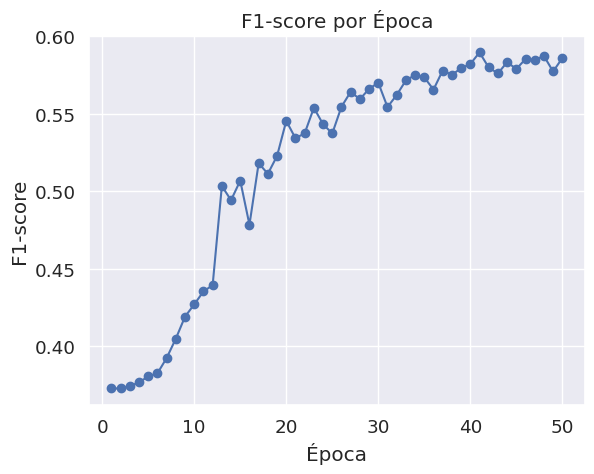

In [ ]:
checkpoint_callback.best_model_path
import matplotlib.pyplot as plt

# Después de completar el entrenamiento
epochs = list(range(1, len(pl_model.val_f1_scores) + 1))
plt.plot(epochs, pl_model.val_f1_scores, marker='o')
plt.xlabel('Época')
plt.ylabel('F1-score')
plt.title('F1-score por Época')
plt.grid(True)
plt.show()

In [ ]:
best_model = checkpoint_callback.best_model_path
# best_model = "/content/drive/MyDrive/Wav2Vec2_ORVP/wav2vec2_huggingface_fairseq_orvp_test1-epoch=4-step=23459.ckpt"
print(best_model)
test_model = Wav2Vec2_sound_detection.load_from_checkpoint(best_model, hparams=hparams).cuda().eval()

/home/cslab03/Desktop/QuakeWavNet/wav2vec2-sound_sismic_train-v4.ckpt


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2_ChannelModel: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.feature_extractor.conv_layers.6.conv.weight']
- This IS expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2_ChannelModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2_ChannelModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False, num_workers=0)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

MulticlassConfusionMatrix()
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6444887518882751
         test_f1            0.6048702001571655
        test_loss           0.6365034580230713
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6444887518882751,
  'test_f1': 0.6048702001571655,
  'test_loss': 0.6365034580230713}]

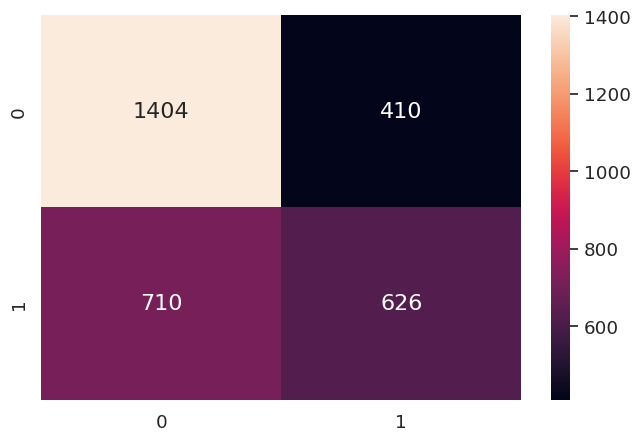

In [ ]:
trainer.test(test_model, test_dataloader)

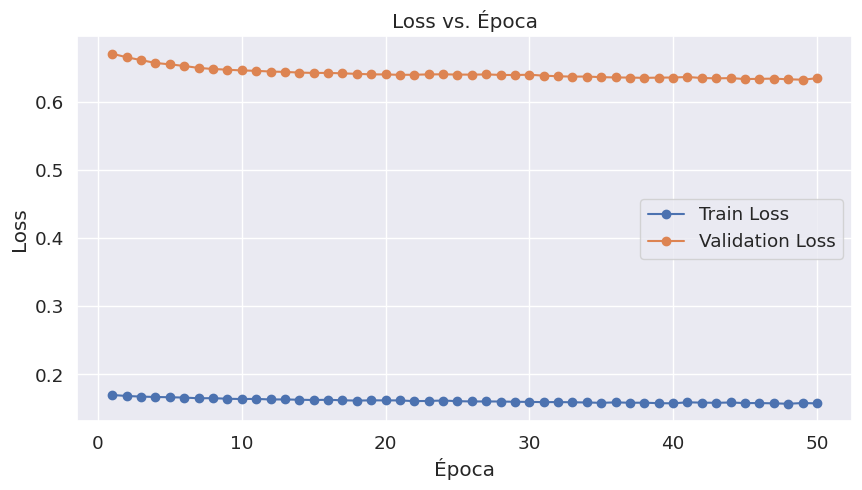

In [ ]:
import matplotlib.pyplot as plt

# Después de completar el entrenamiento
epochs = list(range(1, len(pl_model.train_losses) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, pl_model.train_losses, label='Train Loss', marker='o')
plt.plot(epochs, pl_model.val_losses, label='Validation Loss', marker='o')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss vs. Época')
plt.legend()
plt.grid(True)
plt.show()
